<h2> Plot Wyoming Cloud Radar data

In [1]:
# Load the needed packages
import os
import matplotlib.pyplot as plt
import numpy as np

import awot
import awot
from awot.graph import FlightLevel, RadarVerticalPlot, MicrophysicalVerticalPlot

%matplotlib inline

Supply input data and plotting characteristics

In [2]:
file1 = "WCR.TEST14.20140917.183235_185638.down.nc"
#file = "WCR.TEST14.20140618.200302_201559.up.nc"
wcrf1 = os.path.join("/Users/guy/data/king_air/test2014/wcr", file1)

file = "WCR.OWLES13.20140127.203210_210457.up-down.nc"
wcrf2 = os.path.join("/Users/guy/data/king_air/owles2013/wcr/", file)

start_time = "2014-09-07 18:32:35"
end_time = "2014-09-07 18:56:37"

# Set the project name
Project="TEST14"

#TEST2014
#altmin, altmax = 1500., 8000.

#OWLES2013
altmin, altmax = 0., 3000.

refmin, refmax = -50., 30.
#velmin, velmax = -16., 16. # Nyquist
velmin, velmax = -3., 3. # Nyquist

Read in the radar data

In [3]:
wcr = awot.io.read_wcr2(fname=wcrf2)

height_zdr does not exist in file...
height_ldr does not exist in file...
zdr does not exist in file...
ldr does not exist in file...


In [4]:
print(wcr.keys())
print("Reflectivity Min/Max = %f / %f \n"
      "Velocity Min/Max = %f / %f \n"
      "Altitude Min/Max = %f / %f \n"
      "Height Min/Max = %f / %f \n"
      "Surface Min/Max = %f / %f \n"%(
        wcr['fields']['reflectivity']['data'].min(),wcr['fields']['reflectivity']['data'].max(),
        wcr['fields']['velocity']['data'].min(),wcr['fields']['velocity']['data'].max(),
        wcr['altitude']['data'].min(), wcr['altitude']['data'].max(),
        wcr['height']['data'].min(), wcr['height']['data'].max(),
        wcr['surface']['data'].min(), wcr['surface']['data'].max()))

['fields', 'tas', 'ground_speed', 'aircraft_wind', 'reflectivity_minimum', 'data_format', 'longitude', 'height', 'project', 'platform', 'flight_number', 'height_ldr', 'surface', 'aspect', 'time', 'latitude', 'altitude', 'height_zdr', 'beam_vector', 'metadata']
Reflectivity Min/Max = -54.610954 / 46.513153 
Velocity Min/Max = -15.402483 / 15.429156 
Altitude Min/Max = 1013.030029 / 2786.558594 
Height Min/Max = 66.791504 / 2905.298340 
Surface Min/Max = 0.000000 / 592.440918 



Make a vertical plot of reflectivity and velocity fields

/Users/guy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


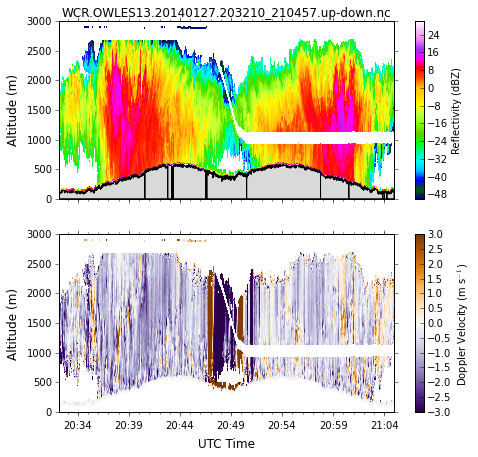

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)


wcr_vp= RadarVerticalPlot(wcr)

wcr_vp.time_height_image('reflectivity', ax=ax1, plot_log10_var=False,
#              start_time=start_time, end_time=end_time,
                         vmin=refmin, vmax=refmax,
                         fill_surface=True,
                         cb_label=r'Reflectivity (dBZ)',
                         height_min=altmin, height_max=altmax, title=file,
                         ylab=r'Altitude (m)', ylabFontSize=12)
              
wcr_vp.time_height_image('velocity', ax=ax2, plot_log10_var=False,
#              start_time=start_time, end_time=end_time,
                         vmin=velmin, vmax=velmax,
                         cmap="PuOr_r",
                         cb_label=r'Doppler Velocity (m s$^{-1}$)',
                         height_min=altmin, height_max=altmax,
                         ylab=r'Altitude (m)', ylabFontSize=12,
                         xlab='UTC Time', xlabFontSize=12)

<matplotlib.colorbar.Colorbar instance at 0x11d976710>

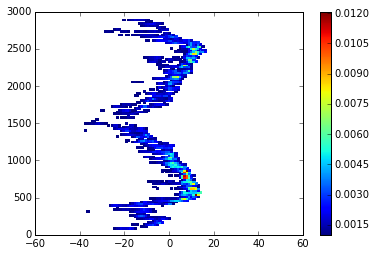

In [6]:
tas2D, Ht2D = np.meshgrid(wcr['tas']['data'][:], wcr['height']['data'][:])

figC, axC = plt.subplots(1, 1)
binx, biny = np.linspace(-50, 50, 100, endpoint=True), np.linspace(0, 3000, 120, endpoint=True)
CFAD, xedges, yedges = np.histogram2d(wcr['fields']['reflectivity']['data'].ravel(), Ht2D.ravel(),
                                      bins=(binx, biny),normed=True)
#CFAD = axC.hist2d(wcr['fields']['reflectivity']['data'].ravel(), Ht2D.ravel(), normed=True,
#                 )#range=[[-40., 25.], [0., 3000.]], bins=[15, 10]
X, Y = np.meshgrid(xedges, yedges)
CFAD = np.ma.masked_where(CFAD < 0.00001, CFAD)
plt.pcolormesh(X, Y, CFAD.T * 100)
#axC.set_aspect('equal')
plt.colorbar()

In [36]:
def create_cfad(radar, fieldname, bins):
    '''Create a CFAD.'''
    # Create CFAD array to fill
    pdf = np.empty((len(radar['height']['data']),len(bins)-1))
    CFAD = np.zeros_like(pdf)
    data = wcr['fields'][fieldname]['data'][:]
    for nn in range(len(CFAD)):
#        pdf[nn, :], bin_edges = np.histogram(data[nn,:], bins=bins, density=False)
#        CFAD[nn, :] = pdf[nn, :]/ np.sum(pdf[nn, :])
        CFAD[nn,:], bin_edges = np.histogram(data[nn,:], bins=bins, density=True)
    return CFAD

In [44]:
binsZ = np.linspace(-40, 20, 61, endpoint=True)
binsW = np.linspace(-5, 5, 51, endpoint=True)
CFADZ = create_cfad(wcr, 'reflectivity', binsZ)
CFADW = create_cfad(wcr, 'velocity', binsW)

CFADZ = np.ma.masked_equal(CFADZ, 0.)
CFADW = np.ma.masked_equal(CFADW, 0.)

TypeError: Shape of x does not match that of z: found (190, 61) instead of (190, 60).

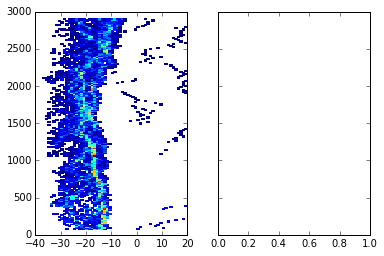

In [59]:
figC, (axZ, axW) = plt.subplots(1, 2, sharey=True)

XZ, YZ = np.meshgrid(binsZ, wcr['height']['data'])
XW, YW = np.meshgrid(binsW, wcr['height']['data'])
#CFAD = np.ma.masked_where(CFAD < 0.00001, CFAD)
p1 = axZ.pcolormesh(XZ, YZ, CFADZ)
axZ.set_xlim(-40, 20)
axZ.set_xlabel('Ze (dBZ)')
axZ.set_ylabel('Altitude (m)')
fig.colorbar(p1, ax=axZ)

p2 = axW.pcolormesh(XW, YW, CFADW)
axW.set_xlim(-5, 5)
axW.set_xlabel('W (m/s)')
fig.colorbar(p2, ax=axW)
fig.tight_layout()

In [73]:
print(wcr['fields']['mask']['data'].shape) 
sfcheight = np.empty_like(wcr['time']['data'])
condition = np.equal(wcr['fields']['mask']['data'], 32)
for nn in range(len(sfcheight)):
    if np.any(condition[nn, :]):
        index = np.where(condition[nn, :])[0]
        sfcheight[nn] = wcr['height']['data'][np.where(condition[nn, :])[0][0]]

(9750, 190)


In [31]:
#condition = np.logical_or(wcr['fields']['mask']['data'] == 32)
sfcheight = np.empty_like(wcr['time']['data'])
ind1 = np.where(np.any(wcr['fields']['mask']['data'] == 32, axis=1))
ind2 = np.where(np.any(wcr['fields']['mask']['data'][ind1,:] == 32, axis=0)
sfcheight[ind1, ind2] =

In [53]:
wcr['height']['data'].shape

(190,)

In [74]:
sfcheight

array([None, 81.810059, 81.810059, ..., 111.84717, 111.84717, 111.84717], dtype=object)